### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [226]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [227]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.370,18208.5500
318,PSID134,0,19,11,1,0,0,1,5607.4220,3054.290,94.5745
212,PSID28,0,39,6,0,1,1,1,13279.9100,8441.371,25048.9400
14,NSW15,1,17,7,1,0,0,1,0.0000,0.000,3023.8790
230,PSID46,0,20,12,1,0,1,0,9555.3440,7055.661,0.0000
384,PSID200,0,31,6,0,0,0,1,2666.5620,1321.258,0.0000
195,PSID11,0,41,5,0,0,1,1,10785.7600,11991.580,19451.3100
555,PSID371,0,26,14,0,0,0,0,0.0000,0.000,6717.7450
138,NSW139,1,29,12,1,0,0,0,10881.9400,1817.284,0.0000
228,PSID44,0,21,12,0,0,1,0,13601.2300,7202.468,10746.0300


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [228]:
''' your code and explanations ''';
treatment_group = df[df['treat'] == 1]
control_group = df[df['treat'] == 0]

### Numerical summaries

In [229]:
treatment_group['re78'].describe(), control_group['re78'].describe()

(count      185.000000
 mean      6349.143530
 std       7867.402218
 min          0.000000
 25%        485.229800
 50%       4232.309000
 75%       9642.999000
 max      60307.930000
 Name: re78, dtype: float64,
 count      429.000000
 mean      6984.169742
 std       7294.161791
 min          0.000000
 25%        220.181300
 50%       4975.505000
 75%      11688.820000
 max      25564.670000
 Name: re78, dtype: float64)

- mean re78(control) > mean re78(treatment) --> we might think that the treatment (job training) descreases the revenue
- max re78(control) < max re78(treatment) --> the job training increases the maximum revenue


### Graphical summaries

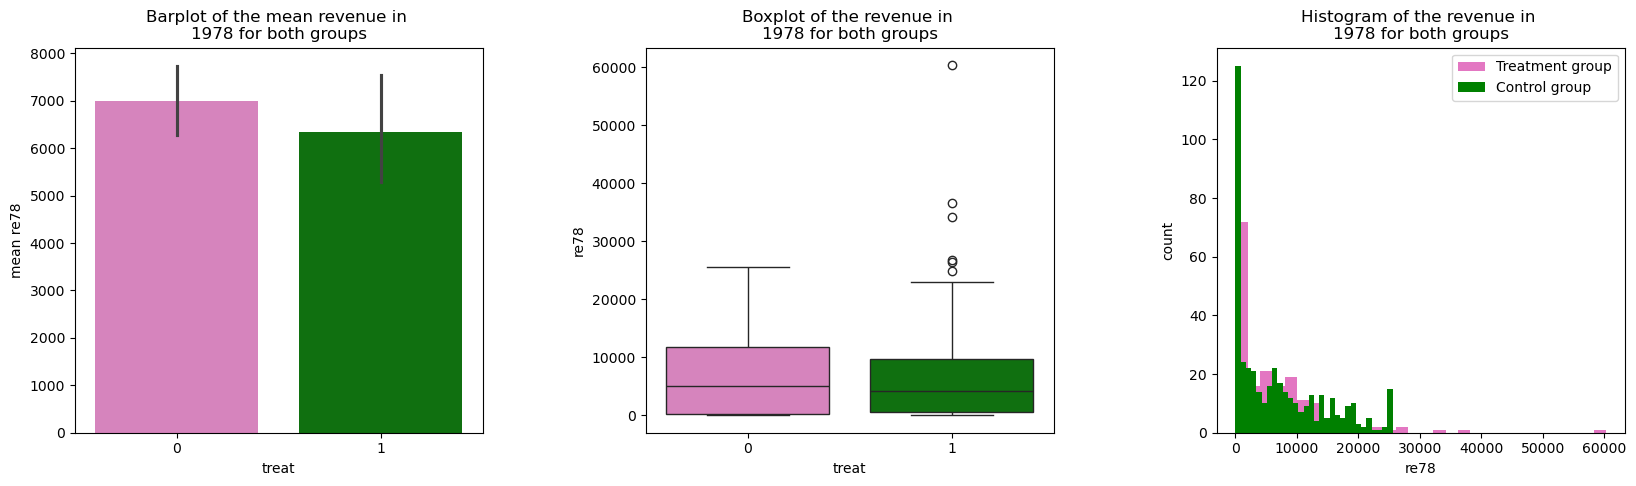

In [230]:
# define figure
fig, axs = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.4)

# plots
sns.barplot(x="treat", y="re78", hue='treat', data=df, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[0])
sns.boxplot(x="treat", y="re78", hue='treat', data=df, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[1])
plt.hist(treatment_group['re78'], bins=30, color='tab:pink', label='Treatment group')
plt.hist(control_group['re78'], bins=30, color='g', label='Control group')
plt.legend()


# format the plots 
axs[0].set_title('Barplot of the mean revenue in \n1978 for both groups')
axs[0].set_ylabel('mean re78')

axs[1].set_title('Boxplot of the revenue in \n1978 for both groups')
axs[1].set_ylabel('re78')

axs[2].set_title('Histogram of the revenue in \n1978 for both groups')
axs[2].set_xlabel('re78')
axs[2].set_ylabel('count')


plt.show()

- We see that the CI for the treatment group is larger than for the control group --> more variance
- From the histograms and boxplots we see that the treatment group has a few outliers with high revenue.

From this superficial analysis, a naive researcher might conclude that doing the job training lowers your revenue. 

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

### Numerical summaries

In [231]:
treatment_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [232]:
control_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


- there are 3x more people in the control group (n=429) than in the treatment group (n=185)
- the mean revenue pre-treatment is higher in the control group than in the treatment group

### Graphical summaries

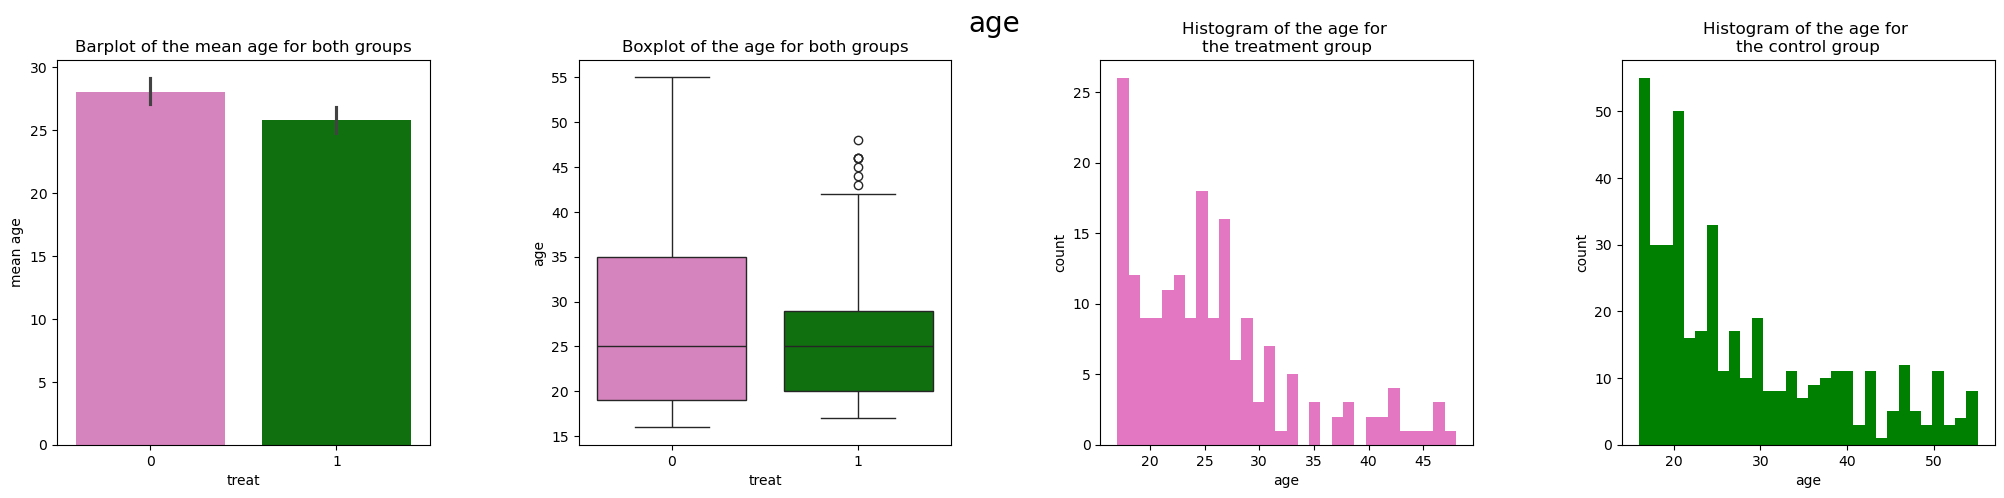

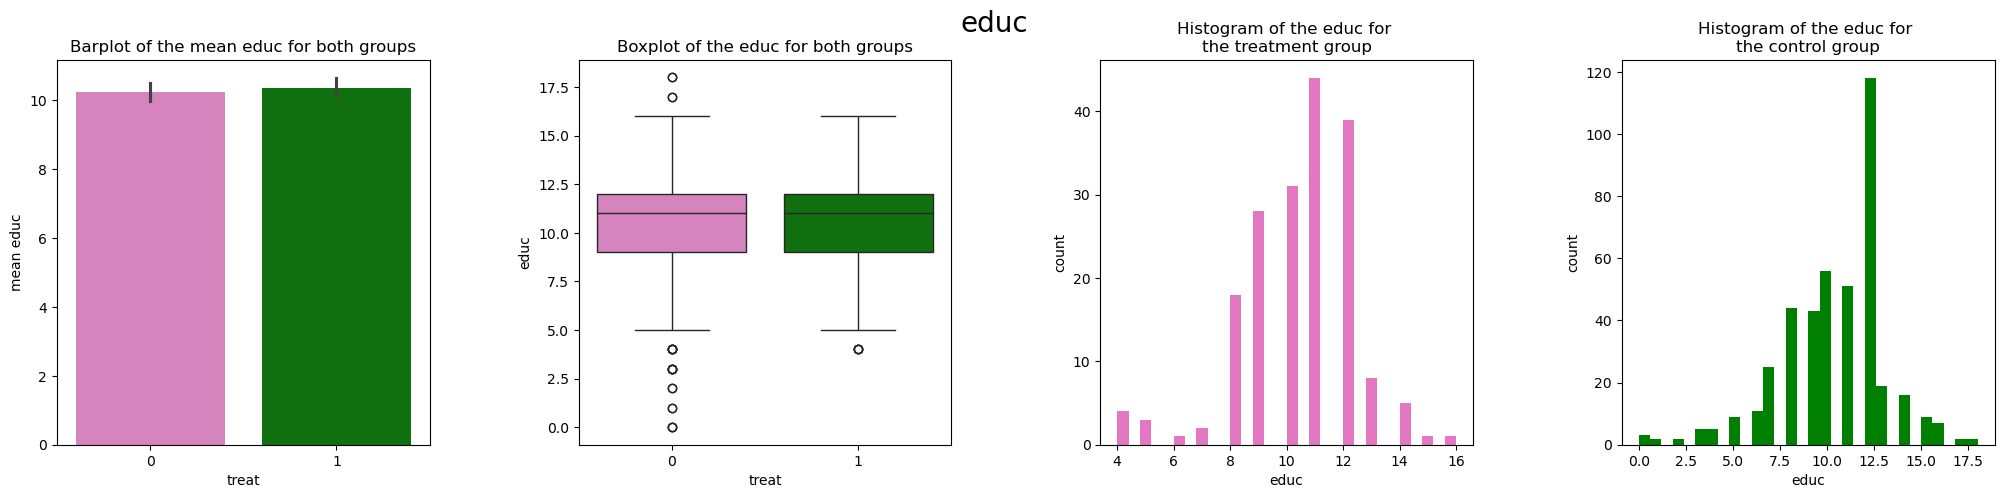

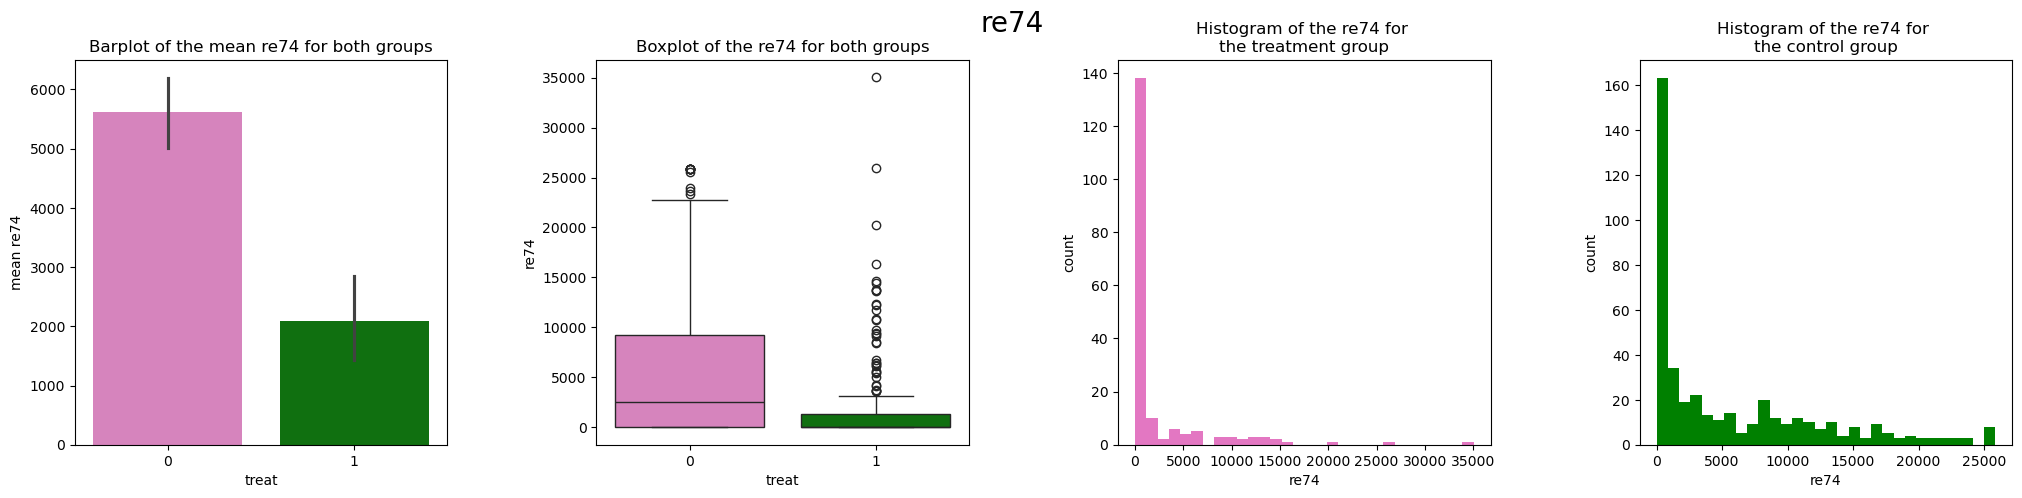

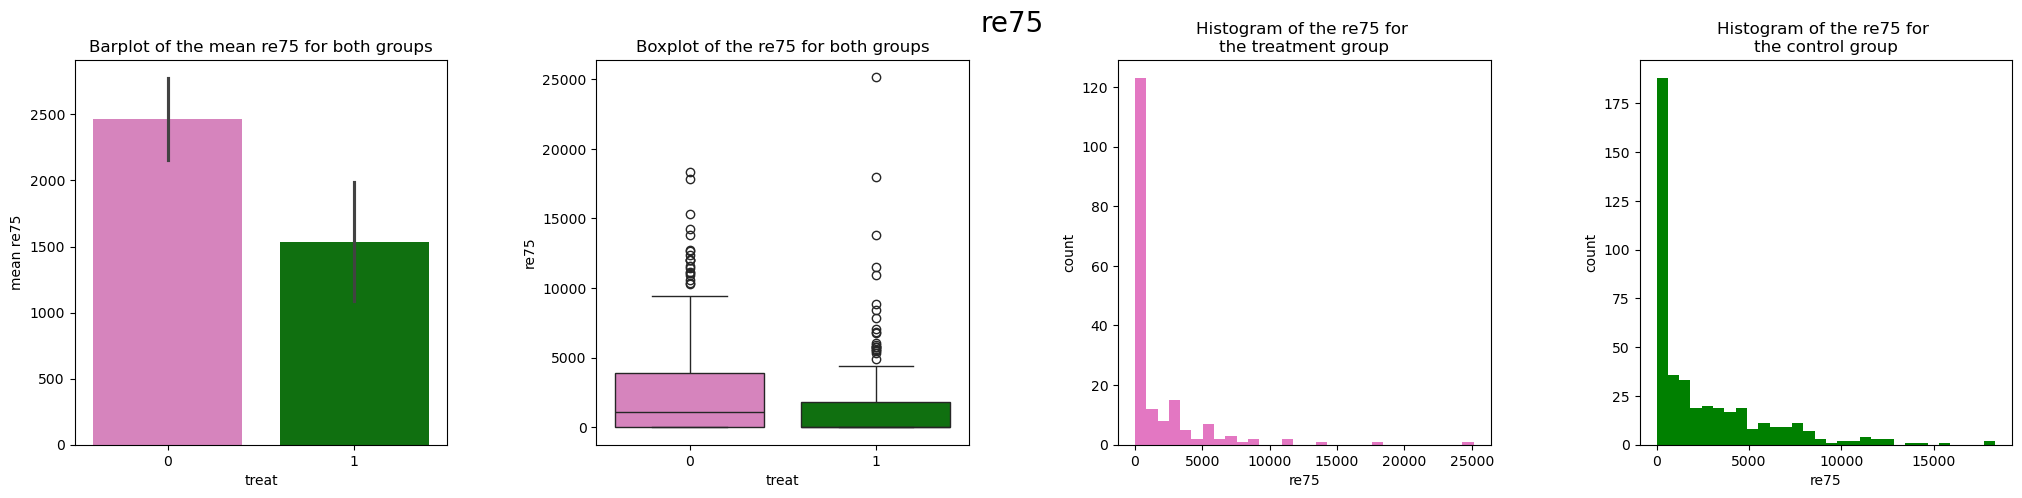

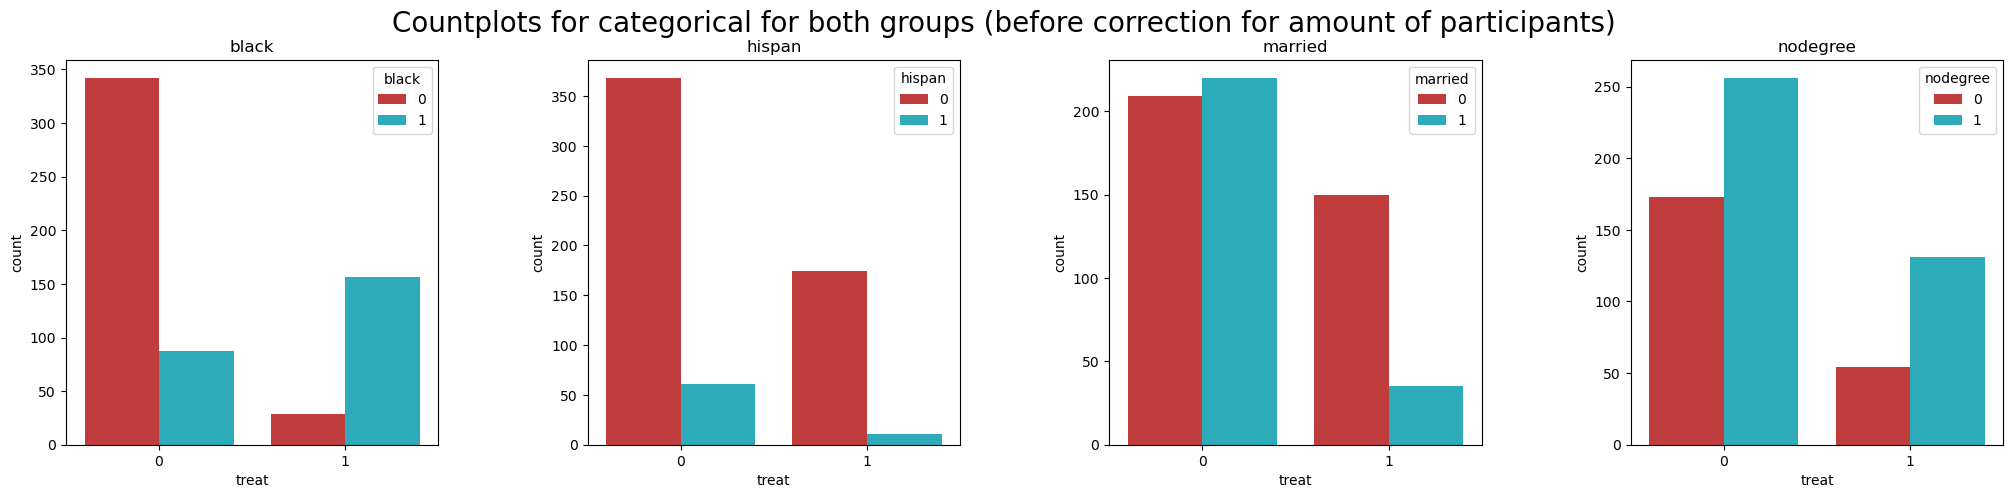

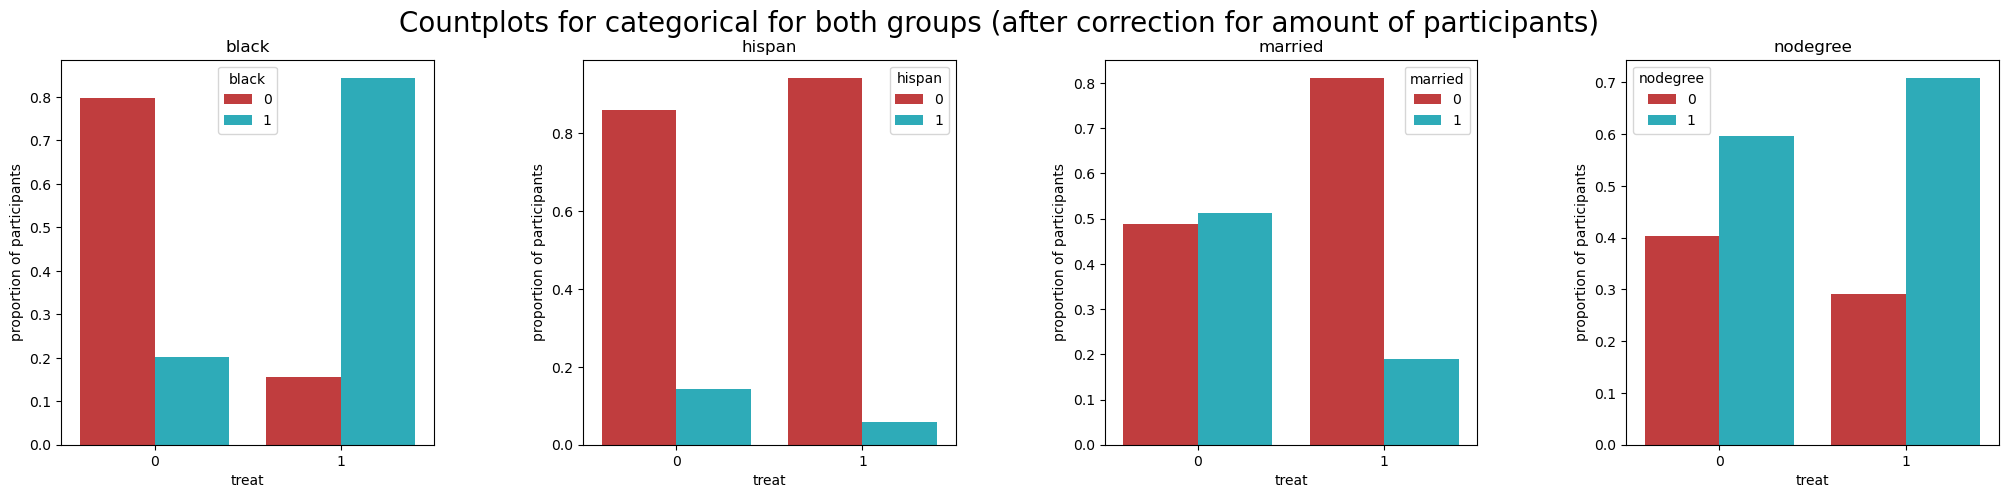

In [233]:
#define a for-loop to loop over all variables in the dataset
numerical_variables = ['age', 'educ', 're74', 're75']
categorical_variables = ['black', 'hispan', 'married', 'nodegree']

# graphical summaires for numerical variables
for variable in numerical_variables: 

    # define figure
    fig, axs = plt.subplots(1, 4, figsize=(25,5))
    plt.subplots_adjust(wspace=0.4)

    # plots
    sns.barplot(x="treat", y=variable, hue='treat', data=df, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[0])
    sns.boxplot(x="treat", y=variable, hue='treat', data=df, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[1])
    axs[2].hist(treatment_group[variable], bins=30, color='tab:pink')
    axs[3].hist(control_group[variable], bins=30, color='g')

    # format the plots 
    axs[0].set_title(f'Barplot of the mean {variable} for both groups')
    axs[0].set_ylabel(f'mean {variable}')

    axs[1].set_title(f'Boxplot of the {variable} for both groups')
    axs[1].set_ylabel(variable)

    axs[2].set_title(f'Histogram of the {variable} for \nthe treatment group')
    axs[2].set_xlabel(variable)
    axs[2].set_ylabel('count')

    axs[3].set_title(f'Histogram of the {variable} for \nthe control group')
    axs[3].set_xlabel(variable)
    axs[3].set_ylabel('count')

    plt.suptitle(variable, fontsize=20)
    plt.show()

# graphical summaries for categorical variables
fig, axs = plt.subplots(1, 4, figsize=(25,5))
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Countplots for categorical for both groups (before correction for amount of participants)', fontsize=20)
i=0

for variable in categorical_variables:
    # plots
    sns.countplot(x="treat", hue=variable, data=df, palette=sns.color_palette(['tab:red', 'tab:cyan']), ax=axs[i])
    
    # format the plots 
    axs[i].set_title(variable)
    axs[i].set_ylabel(f'count')

    i+=1

fig, axs = plt.subplots(1, 4, figsize=(25,5))
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Countplots for categorical for both groups (after correction for amount of participants)', fontsize=20)
i=0

for variable in categorical_variables:
    # calculate proportions 
    counts = df.groupby(['treat', variable]).size().reset_index(name='count')
    total_counts = df.groupby('treat').size().reset_index(name='total')
    counts = pd.merge(counts, total_counts, on='treat')
    counts['proportion'] = counts['count'] / counts['total']

    # plots
    sns.barplot(x="treat", y='proportion', hue=variable, data=counts, palette=sns.color_palette(['tab:red', 'tab:cyan']), ax=axs[i])
    
    # format the plots 
    axs[i].set_title(variable)
    axs[i].set_ylabel('proportion of participants')

    i+=1

- in the treated group, there are almost only black people, and in the control group, there are mostly white people (0 at black and 0 at hispanic)

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [234]:
''' your code and explanations ''';
# standardize hte continuous features 
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean()) / df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean()) / df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean()) / df['re75'].std()


# In a propensity score estimation context, the dependent variable should be the treatment indicator (e.g., whether a participant is in the treatment group or not), not the outcome variable (like re78).

# Fit the logistic regression model using the formula interface
mod = smf.logit(formula='treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75', data=df)
results = mod.fit()
print(results.summary())

df['propensity_score'] = results.predict()
df['propensity_score']

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                  0.3508
Time:                        13:01:54   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

0      0.638770
1      0.224634
2      0.678244
3      0.776324
4      0.701639
         ...   
609    0.123144
610    0.034560
611    0.183351
612    0.383032
613    0.089712
Name: propensity_score, Length: 614, dtype: float64

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [235]:
# we need to define a function that calculates the similarity between 2 people in the dataset based on their propensity scores 

def get_similarity(person1, person2):
    """Calculates the difference in propensity scores of the 2 given persons

    Args:
        person1 (panda series): first person to be considered
        person2 (panda series): second person to be considered
    """
    return 1 - np.abs(person1['propensity_score'] - person2['propensity_score'])

In [238]:
# get people that are in treatment or control group
treatment_group = df[df['treat'] == 1]
control_group = df[df['treat'] == 0]

# empty undirected graph
G = nx.Graph()

# we need a double for-loop to construct all optimal pairs of people
for control_id, control_row in control_group.iterrows():
    for treatment_id, treatment_row in treatment_group.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row, treatment_row)

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G) # contains all pairs of matched people

In [239]:
# get all rows that are in the matching sets 
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

# take only rows in the original dataset that are matched between the 2 groups
balanced_df_1 = df.iloc[matched]
print(df.shape, balanced_df_1.shape)
print(f"Propensity score balancing removed {len(df) - len(balanced_df_1)} rows")

(614, 12) (370, 12)
Propensity score balancing removed 244 rows


In [240]:
balanced_treatment_group = balanced_df_1[balanced_df_1['treat'] == 1]
balanced_control_group = balanced_df_1[balanced_df_1['treat'] == 0]

### Numerical summaries

In [241]:
balanced_treatment_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,-0.156558,0.029379,0.843243,0.059459,0.189189,0.708108,-0.380053,-0.198103,6349.143530,0.577436
std,0.0,0.724105,0.764993,0.364558,0.237124,0.392722,0.455867,0.754345,0.976810,7867.402218,0.220285
min,1.0,-1.048780,-2.385067,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,0.000000,0.024952
25%,1.0,-0.745173,-0.482714,1.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,485.229800,0.526464
50%,1.0,-0.239161,0.278227,1.000000,0.000000,0.000000,1.000000,-0.703546,-0.662971,4232.309000,0.653684
75%,1.0,0.165649,0.658697,1.000000,0.000000,0.000000,1.000000,-0.504183,-0.111556,9642.999000,0.726600
max,1.0,2.088495,2.180579,1.000000,1.000000,1.000000,1.000000,4.705571,6.965879,60307.930000,0.853153


In [242]:
balanced_control_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,-0.208527,0.128095,0.47027,0.216216,0.210811,0.637838,-0.341996,-0.173012,5454.776050,0.362891
std,0.0,1.071365,1.011384,0.50047,0.412781,0.408991,0.481930,0.654368,0.798729,6063.836916,0.253257
min,0.0,-1.149982,-3.526478,0.00000,0.000000,0.000000,0.000000,-0.703546,-0.662971,0.000000,0.024896
25%,0.0,-0.947578,-0.482714,0.00000,0.000000,0.000000,0.000000,-0.703546,-0.662971,0.000000,0.115687
50%,0.0,-0.745173,0.278227,0.00000,0.000000,0.000000,1.000000,-0.653944,-0.571707,3358.873000,0.261248
75%,0.0,0.165649,0.658697,1.00000,0.000000,0.000000,1.000000,-0.340000,-0.089316,7933.914000,0.646269
max,0.0,2.796912,2.941520,1.00000,1.000000,1.000000,1.000000,2.679974,3.517209,23764.800000,0.789173


- Now we have the same number of people in both groups (n=185)
- Race is still not balanced

### Gaphical summaries 

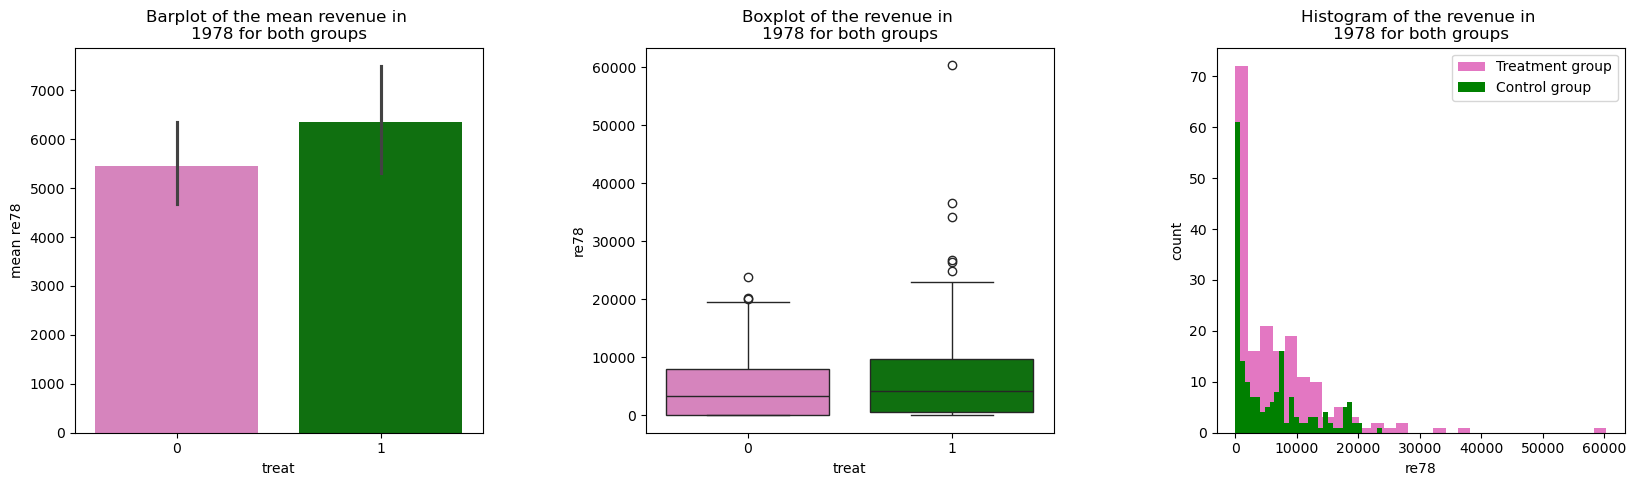

In [243]:
# define figure
fig, axs = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.4)

# plots
sns.barplot(x="treat", y="re78", hue='treat', data=balanced_df_1, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[0])
sns.boxplot(x="treat", y="re78", hue='treat', data=balanced_df_1, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[1])
plt.hist(balanced_treatment_group['re78'], bins=30, color='tab:pink', label='Treatment group')
plt.hist(balanced_control_group['re78'], bins=30, color='g', label='Control group')
plt.legend()


# format the plots 
axs[0].set_title('Barplot of the mean revenue in \n1978 for both groups')
axs[0].set_ylabel('mean re78')

axs[1].set_title('Boxplot of the revenue in \n1978 for both groups')
axs[1].set_ylabel('re78')

axs[2].set_title('Histogram of the revenue in \n1978 for both groups')
axs[2].set_xlabel('re78')
axs[2].set_ylabel('count')


plt.show()

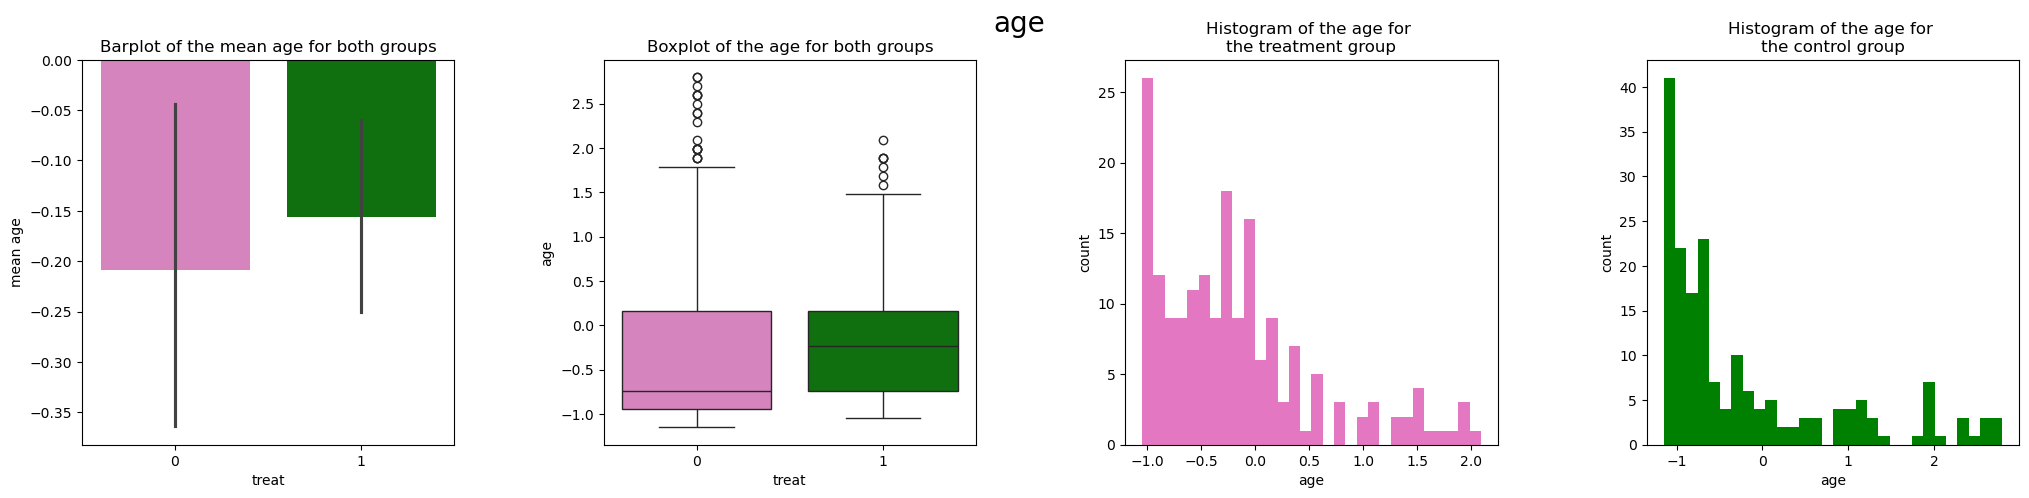

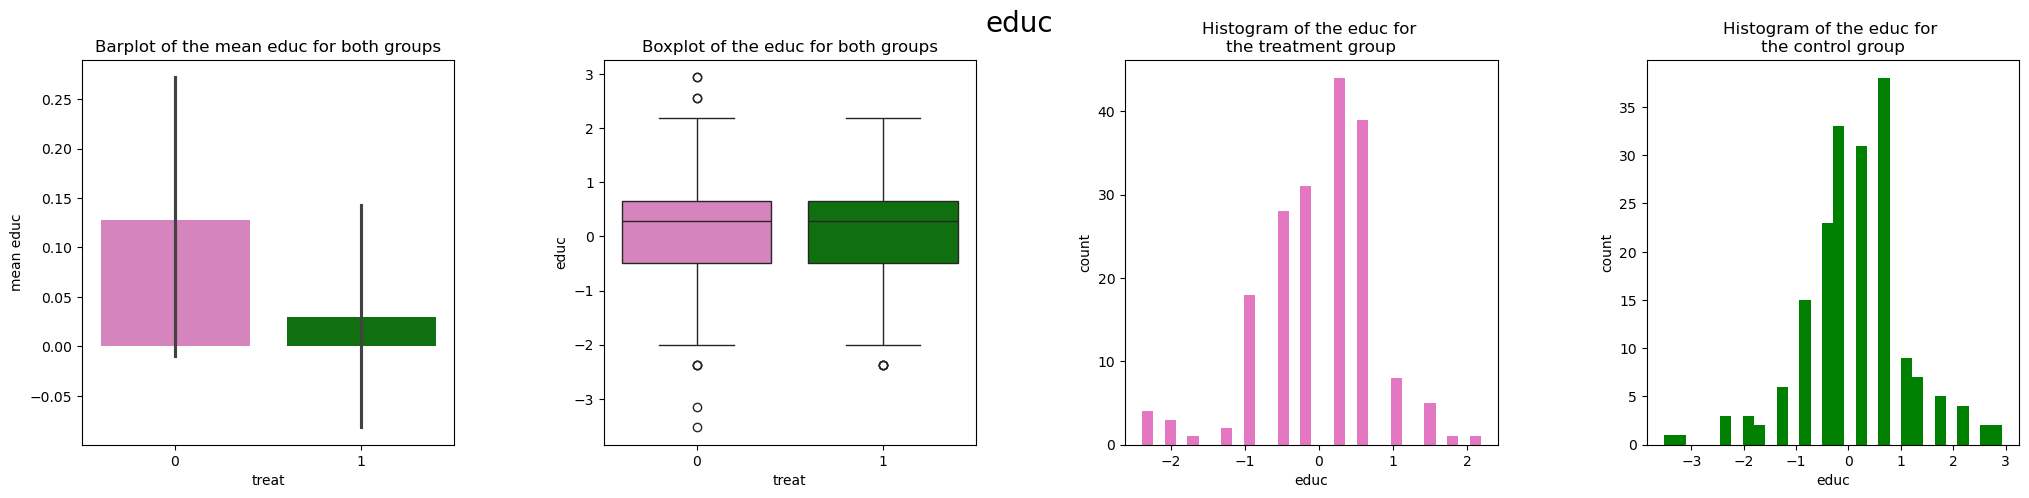

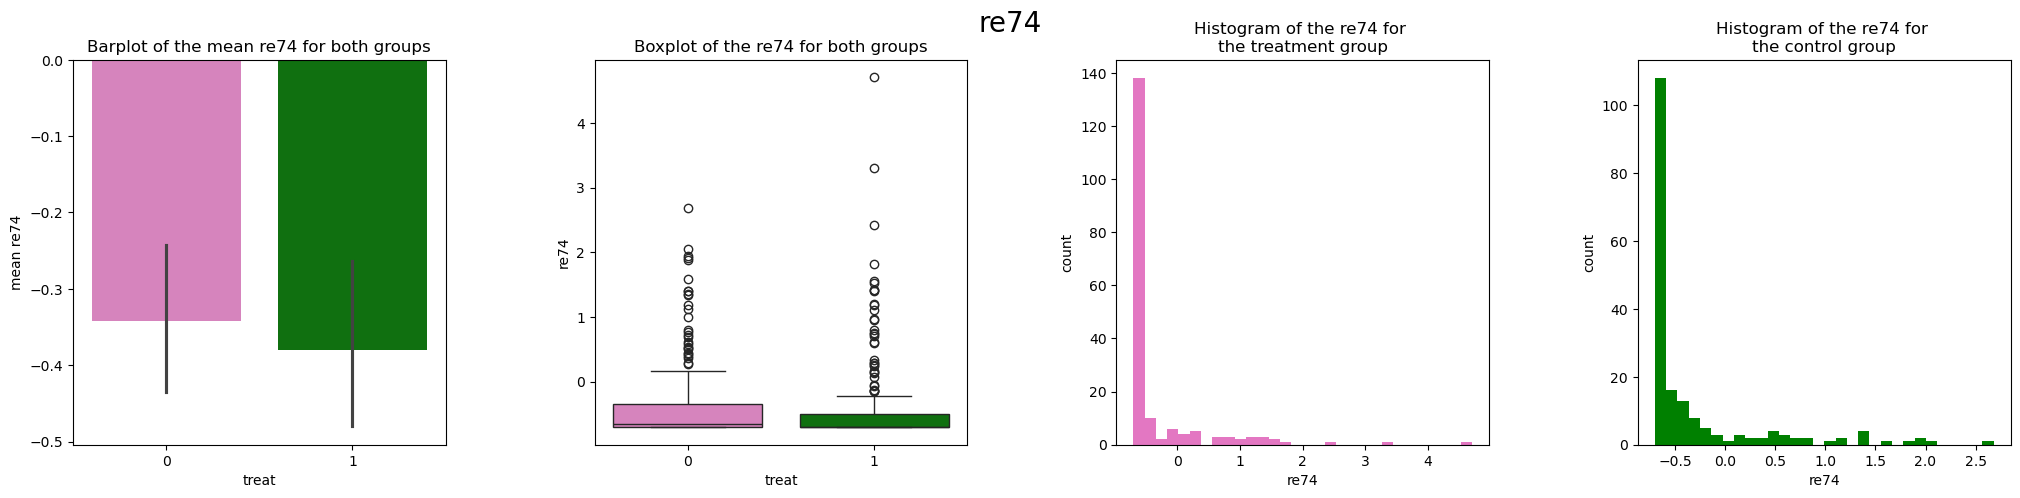

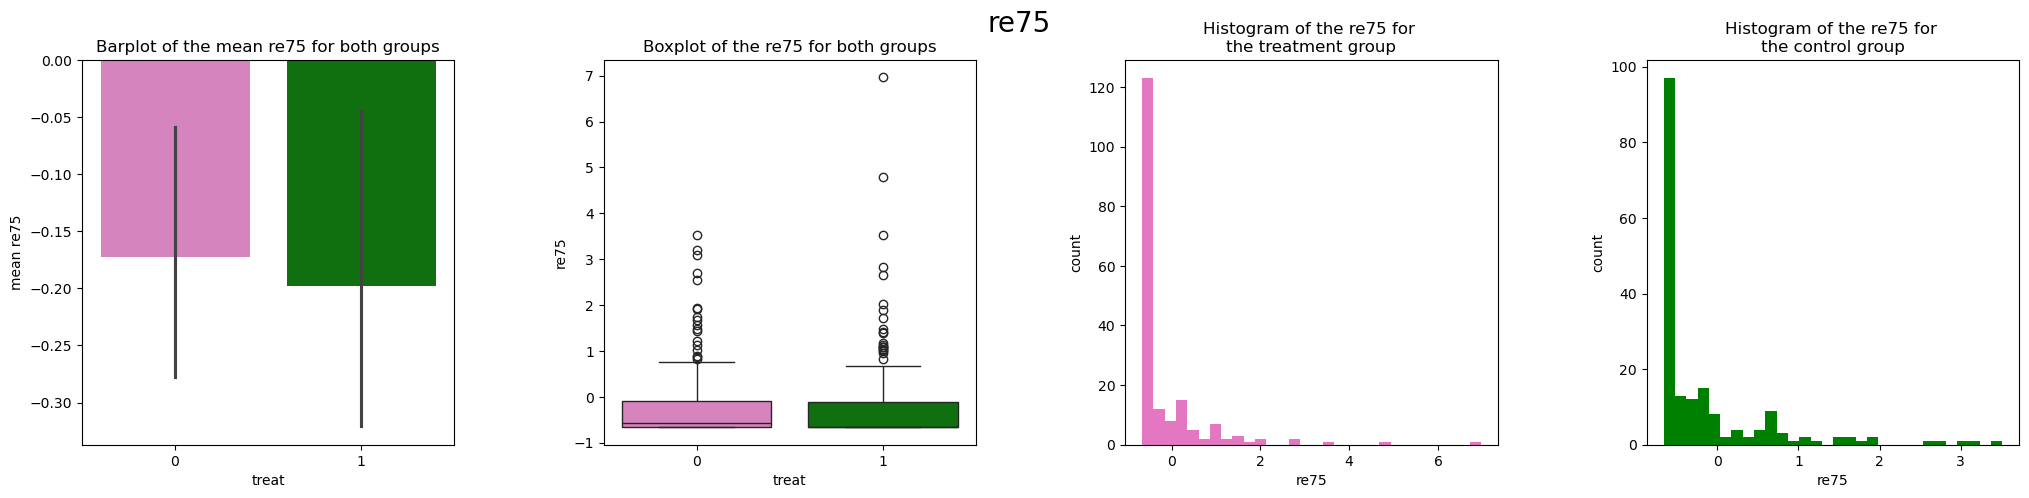

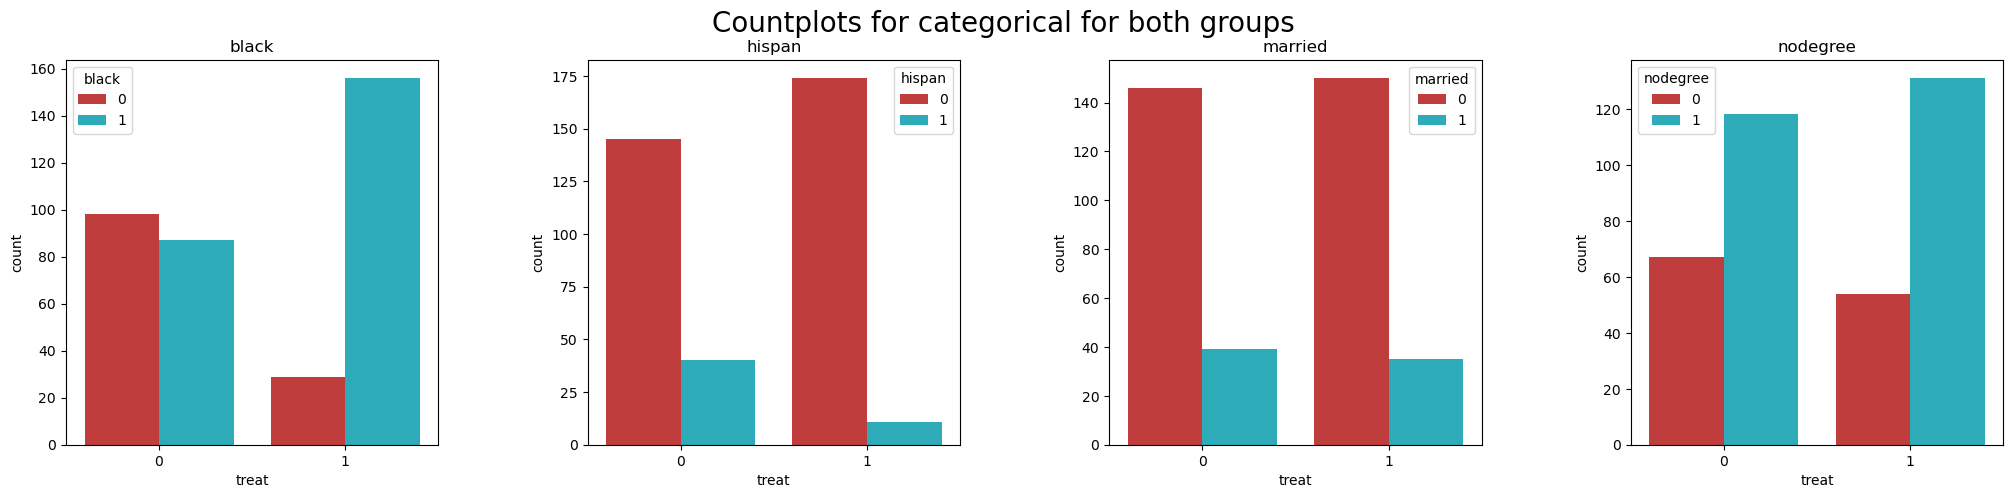

In [244]:
#define a for-loop to loop over all variables in the dataset
numerical_variables = ['age', 'educ', 're74', 're75']
categorical_variables = ['black', 'hispan', 'married', 'nodegree']

# graphical summaires for numerical variables
for variable in numerical_variables: 

    # define figure
    fig, axs = plt.subplots(1, 4, figsize=(25,5))
    plt.subplots_adjust(wspace=0.4)

    # plots
    sns.barplot(x="treat", y=variable, hue='treat', data=balanced_df_1, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[0])
    sns.boxplot(x="treat", y=variable, hue='treat', data=balanced_df_1, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[1])
    axs[2].hist(balanced_treatment_group[variable], bins=30, color='tab:pink')
    axs[3].hist(balanced_control_group[variable], bins=30, color='g')

    # format the plots 
    axs[0].set_title(f'Barplot of the mean {variable} for both groups')
    axs[0].set_ylabel(f'mean {variable}')

    axs[1].set_title(f'Boxplot of the {variable} for both groups')
    axs[1].set_ylabel(variable)

    axs[2].set_title(f'Histogram of the {variable} for \nthe treatment group')
    axs[2].set_xlabel(variable)
    axs[2].set_ylabel('count')

    axs[3].set_title(f'Histogram of the {variable} for \nthe control group')
    axs[3].set_xlabel(variable)
    axs[3].set_ylabel('count')

    plt.suptitle(variable, fontsize=20)
    plt.show()

# graphical summaries for categorical variables
fig, axs = plt.subplots(1, 4, figsize=(25,5))
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Countplots for categorical for both groups', fontsize=20)
i=0

for variable in categorical_variables:
    # plots
    sns.countplot(x="treat", hue=variable, data=balanced_df_1, palette=sns.color_palette(['tab:red', 'tab:cyan']), ax=axs[i])
    
    # format the plots 
    axs[i].set_title(variable)
    axs[i].set_ylabel(f'count')

    i+=1

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [245]:
# get people that are in treatment or control group
treatment_group = df[df['treat'] == 1]
control_group = df[df['treat'] == 0]

# empty undirected graph
G = nx.Graph()

# we need a double for-loop to construct all optimal pairs of people
for control_id, control_row in control_group.iterrows():
    for treatment_id, treatment_row in treatment_group.iterrows():
        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black']) and (control_row['hispan'] == treatment_row['hispan']):
            # Calculate the similarity 
            similarity = get_similarity(control_row, treatment_row)

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G) # contains all pairs of matched people

In [246]:
# get all rows that are in the matching sets 
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

# take only rows in the original dataset that are matched between the 2 groups
balanced_df_2 = df.iloc[matched]
print(df.shape, balanced_df_2.shape)
print(f"Propensity score balancing removed {len(df) - len(balanced_df_2)} rows")

(614, 12) (232, 12)
Propensity score balancing removed 382 rows


The problem is that the race category is not properly balanced. There are still more black people in the treatment group and more white people in the control group. We need to add a condition on race features in the similarity matching, i.e. consider that 2 people are similar (so matched) only when their propensity score difference is minimized AND that have the same hispanic and black features. 

In [248]:
balanced2_treatment_group = balanced_df_2[balanced_df_2['treat'] == 1]
balanced2_control_group = balanced_df_2[balanced_df_2['treat'] == 0]

### Numerical summaries

In [249]:
balanced2_treatment_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.0,-0.170238,-0.056325,0.750000,0.094828,0.241379,0.672414,-0.274009,-0.133883,6375.738003,0.497216
std,0.0,0.754573,0.841318,0.434891,0.294248,0.429776,0.471369,0.900678,1.138768,6670.986821,0.239190
min,1.0,-1.048780,-2.385067,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,0.000000,0.024952
25%,1.0,-0.745173,-0.482714,0.750000,0.000000,0.000000,0.000000,-0.703546,-0.662971,758.102600,0.282563
50%,1.0,-0.340363,-0.102244,1.000000,0.000000,0.000000,1.000000,-0.703546,-0.662971,4648.736000,0.599425
75%,1.0,0.165649,0.658697,1.000000,0.000000,0.000000,1.000000,-0.334934,-0.119069,10160.440000,0.686287
max,1.0,2.088495,1.419638,1.000000,1.000000,1.000000,1.000000,4.705571,6.965879,36646.950000,0.789723


In [252]:
balanced2_control_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.000000,116.000000,116.000000,116.000000
mean,0.0,-0.123999,0.042073,0.750000,0.094828,0.275862,0.62069,-0.226435,-0.070607,5095.456025,0.490073
std,0.0,1.066851,1.040033,0.434891,0.294248,0.448887,0.48732,0.766129,0.908687,6047.014862,0.238884
min,0.0,-1.149982,-3.526478,0.000000,0.000000,0.000000,0.00000,-0.703546,-0.662971,0.000000,0.024896
25%,0.0,-0.947578,-0.482714,0.750000,0.000000,0.000000,0.00000,-0.703546,-0.662971,0.000000,0.292026
50%,0.0,-0.593369,0.278227,1.000000,0.000000,0.000000,1.00000,-0.595874,-0.545904,2256.488500,0.599952
75%,0.0,0.469256,0.658697,1.000000,0.000000,1.000000,1.00000,-0.209417,0.218969,8942.092750,0.686317
max,0.0,2.796912,2.561050,1.000000,1.000000,1.000000,1.00000,2.679974,3.517209,20243.380000,0.789173


### Graphical summaries

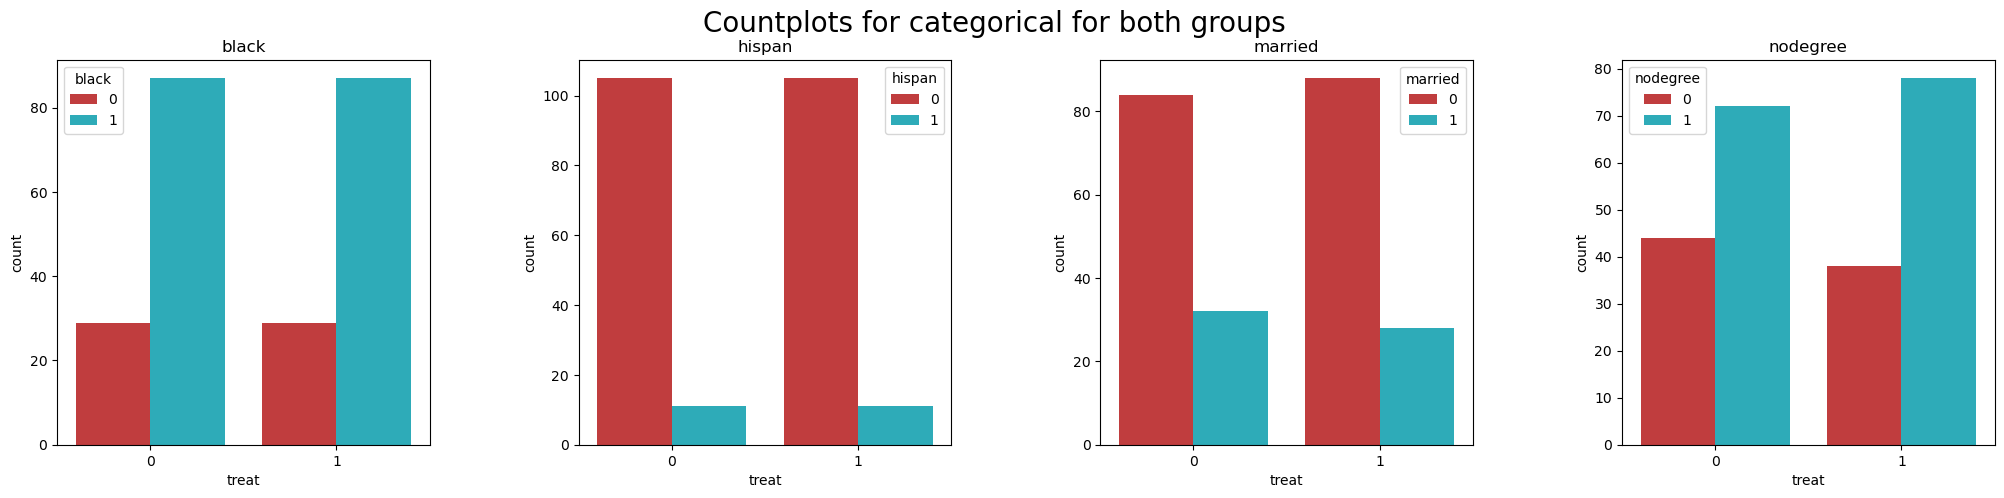

In [254]:
# graphical summaries for categorical variables
fig, axs = plt.subplots(1, 4, figsize=(25,5))
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Countplots for categorical for both groups', fontsize=20)
i=0

for variable in categorical_variables:
    # plots
    sns.countplot(x="treat", hue=variable, data=balanced_df_2, palette=sns.color_palette(['tab:red', 'tab:cyan']), ax=axs[i])
    
    # format the plots 
    axs[i].set_title(variable)
    axs[i].set_ylabel(f'count')

    i+=1

- Now everything seems matched!!!

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

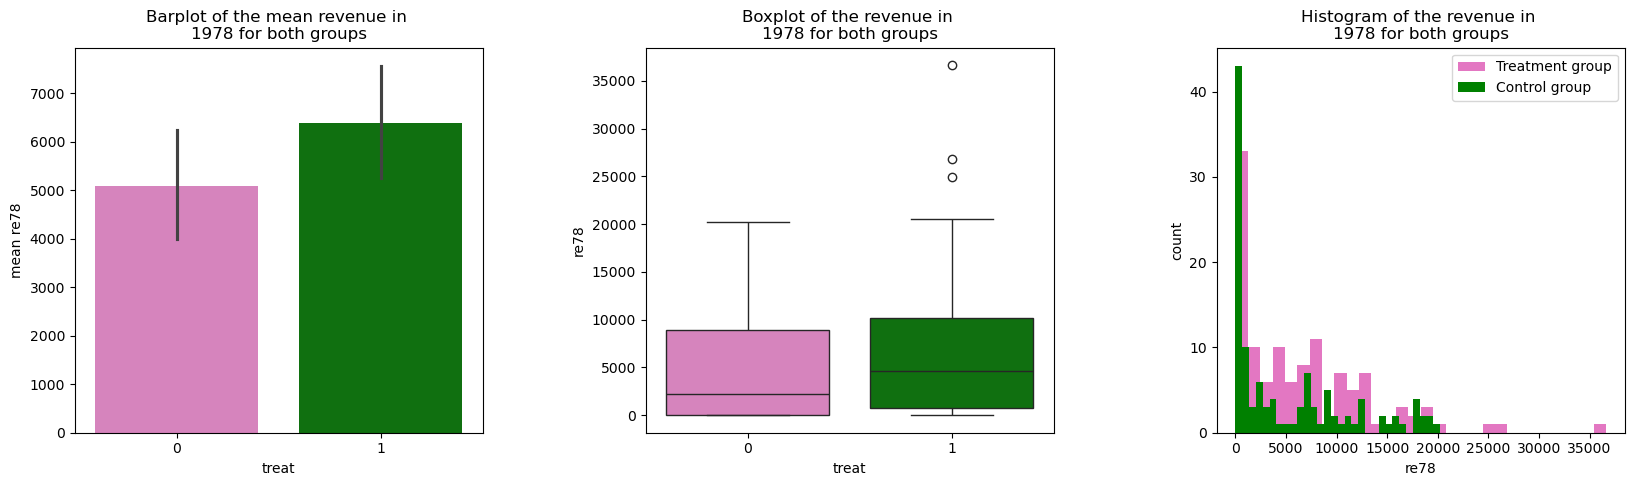

In [255]:
# define figure
fig, axs = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.4)

# plots
sns.barplot(x="treat", y="re78", hue='treat', data=balanced_df_2, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[0])
sns.boxplot(x="treat", y="re78", hue='treat', data=balanced_df_2, palette=sns.color_palette(['tab:pink', 'g']), legend=False, ax=axs[1])
plt.hist(balanced2_treatment_group['re78'], bins=30, color='tab:pink', label='Treatment group')
plt.hist(balanced2_control_group['re78'], bins=30, color='g', label='Control group')
plt.legend()


# format the plots 
axs[0].set_title('Barplot of the mean revenue in \n1978 for both groups')
axs[0].set_ylabel('mean re78')

axs[1].set_title('Boxplot of the revenue in \n1978 for both groups')
axs[1].set_ylabel('re78')

axs[2].set_title('Histogram of the revenue in \n1978 for both groups')
axs[2].set_xlabel('re78')
axs[2].set_ylabel('count')


plt.show()

We can conclude that following the job training indeed increases your mean revenue so you might want to consider the offer !!